# Final exam

**For this exam, feel free to re-use any code from the previous lab notebooks.**

#### Tasks
- Use accelerator data to construct a neural network surrogate model, train that model, and demonstrate that it accurately models the data
- Use Bayesian optimization to optimize the function and determine the best operational parameters

## Setting up the environment

In [1]:
!pip install --upgrade git+https://github.com/uspas/2021_optimization_and_ml --quiet

You should consider upgrading via the '/home/vagrant/.pyenv/versions/3.7.2/envs/py3/bin/python -m pip install --upgrade pip' command.


In [2]:
%reset -f

import numpy as np
import matplotlib.pyplot as plt

#matplotlib graphs will be included in your notebook, next to the code:
%matplotlib inline

#add PyTorch and TorchVision (used for cropping etc.)
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#import toy accelerator package
from uspas_ml.accelerator_toy_models import simple_linarc
from uspas_ml.utils import transformer

## Generate dataset

The code below generates samples from "simulations" of a beam propagating through a linac followed by an arc:
- The input to the simulator are the linac's phase, the arc's R56 coefficient, and the beam final (mean) energy.
- The output of the simulator are the bunch length (in meters) and the bunch's RMS energy spread.

In [3]:
#generate input samples
n = 10000
torch.manual_seed(0)
inputs = torch.rand((n, 3))

#phase +/- 50 deg
inputs[:, 0] = inputs[:, 0] * 100.0 - 50.0

#r56 +/- 0.5
inputs[:,1] = inputs[:,1] - 0.5

#final energy [800,1300]*1e6
inputs[:,2] = (inputs[:,2] * 500.0 + 800.0) * 1e6

print('Inputs:')
print(inputs)

outputs = []
for i in range(n):
    outputs += [simple_linarc.propagate(linac_phase = inputs[i][0], 
                                        arc_r56 = inputs[i][1],
                                        linac_final_E = inputs[i][2])]

outputs = torch.vstack(outputs)

print('Outputs:')
print(outputs)

Inputs:
tensor([[-3.7434e-01,  2.6822e-01,  8.4424e+08],
        [-3.6797e+01, -1.9258e-01,  1.1170e+09],
        [-9.9066e-01,  3.9644e-01,  1.0278e+09],
        ...,
        [ 2.6369e+01, -4.5239e-01,  8.7906e+08],
        [-1.9793e+01, -1.4001e-02,  1.1869e+09],
        [-4.6165e+00, -1.8174e-01,  8.3491e+08]])
Outputs:
tensor([[0.0010, 0.0005],
        [0.0026, 0.0189],
        [0.0011, 0.0006],
        ...,
        [0.0063, 0.0118],
        [0.0009, 0.0089],
        [0.0006, 0.0021]])


<div class="alert alert-block alert-info">
    
**Task:** 
    Appropriately normalize the data.
</div>

In [4]:
tx = transformer.Transformer(inputs, transform_type = 'normalize')
normed_inputs = tx.forward(inputs)

    
ty = transformer.Transformer(outputs, transform_type = 'normalize')
normed_outputs = ty.forward(outputs)

In [5]:
print(normed_inputs)
print(normed_outputs)

tensor([[0.4963, 0.7682, 0.0885],
        [0.1320, 0.3074, 0.6341],
        [0.4902, 0.8965, 0.4557],
        ...,
        [0.7638, 0.0475, 0.1581],
        [0.3021, 0.4860, 0.7740],
        [0.4539, 0.3182, 0.0698]])
tensor([[0.0632, 0.0022],
        [0.1609, 0.6090],
        [0.0665, 0.0057],
        ...,
        [0.3908, 0.3756],
        [0.0523, 0.2787],
        [0.0386, 0.0550]])


<div class="alert alert-block alert-info">
    
**Task:** 
    Create and train a neural network to model this data, i.e. for each data point, the neural network should take the above 3 (normalized) input features and predict the above 2 (normalized) output features. 
    
In order to show that the neural network works as expected and that the training roughly converged, plot the evolution of the loss function - both for the training dataset and test dataset - during training. (Use the first 7000 data points as the training set, and the remaining 3000 data points as the test set.)
</div>

In [6]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        
        hidden_size = 10
        
        self.linear1 = nn.Linear(3, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear3 = nn.Linear(hidden_size, 2)

    def forward(self, x):

        #propagate through model
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        
        return x

def test_model(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.mse_loss(output, target, size_average=False).item()

    test_loss /= len(test_loader.dataset)
#    print(test_loss)
    
    return test_loss
    
def train_model(model, epochs, train_loader):
    
    train_losses = []
    train_counter = []
    
    learning_rate = 0.01
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    #iterate through data batches
    for batch_idx, (data, target) in enumerate(train_loader):
        
        #reset gradients
        optimizer.zero_grad()
        
        #evaluate network with data
        output = model(data)
        
        #compute loss and derivative
        loss = F.mse_loss(output, target)
        loss.backward()
        
        #step optimizer
        optimizer.step()

    return float(loss.detach().numpy())

/home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/ipykernel_launcher

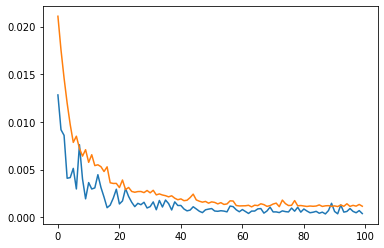

In [7]:
n_train = 7000
n_test = 3000
batch_size = 64
import tqdm

#create test and train datasets
train_data = torch.utils.data.TensorDataset(torch.tensor(normed_inputs[:n_train]).float(),
                                            torch.tensor(normed_outputs[:n_train]).float())

test_data = torch.utils.data.TensorDataset(torch.tensor(normed_inputs[n_train:]).float(),
                                            torch.tensor(normed_outputs[n_train:]).float())

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

model = NN()


train_losses = []
test_losses = []
n_epochs = 100
for epoch in tqdm.tqdm(range(1, n_epochs + 1)):
    train_losses.append( train_model(model, epoch, train_loader) )
    test_losses.append( test_model(model, test_loader) )

plt.plot( train_losses )
plt.plot( test_losses )
#plt.yscale('log')

<div class="alert alert-block alert-info">
    
**Task:** 
    Use Bayesian optimization to minimize the bunch length (i.e. the first of the 2 features that are returned by `simple_linarc`) with respect to phase, r56, and final_energy (i.e. the 3 input features that we passed to `simple_linarc` when previously generating the dataset for the neural network). 
    
Use the first 10 elements of the previously-created arrays `inputs` and `outputs` as the initial dataset on which to fit the initial Gaussian Process (at the beginning of Bayesian optimization). Then, at each iteration of Bayesian optimization, call the `simple_linarc` function on the new candidate point. 
    
Run 6 steps of Bayesian optimization and print the values of the bunch length obtained at each iteration. What is the best value obtained so far?
</div>

In [8]:
import botorch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf

#re-generate initialization data
#-------------------------------------------------------

#generate input space training samples
train_x = inputs[:10]

#do observations of the objective
train_y = outputs[:10,0].reshape(-1,1)

#normalize x
normed_train_x = tx.forward(train_x)
transformer_y = transformer.Transformer(train_y, 
                                        transform_type = 'standardize')

normed_train_y = transformer_y.forward(train_y)
gp = SingleTaskGP(normed_train_x, normed_train_y)

#start optimization
#-------------------------------------------------

n_steps = 6

print(train_y)

for i in range(n_steps):
    
    #Expected Improvement
    best_normed_y = torch.min(normed_train_y)
    EI = ExpectedImprovement(gp, best_normed_y, maximize = False)
    
    
    #optimize acquisition function - see https://botorch.org/api/optim.html# for details
    candidate, acq_value = optimize_acqf(EI, bounds = torch.tensor([ [0.,0.,0.], [1.,1.,1.] ]),
                                             num_restarts = 20, q = 1,
                                             raw_samples = 20)
    
    #add unnormed candidate to training data
    train_x = torch.cat((train_x, tx.backward(candidate)))
    normed_train_x = tx.forward(train_x)
    
    
    #do observation - add to training data - recompute transformer - transform to standardized space
    new_y0 = simple_linarc.propagate( linac_phase=train_x[-1,0], arc_r56=train_x[-1,1], linac_final_E=train_x[-1,2] )
    train_y = torch.cat((train_y, new_y0[:,0].reshape(-1,1)))
    transformer_y = transformer.Transformer(train_y, 
                                        transform_type = 'standardize')

    normed_train_y = transformer_y.forward(train_y)
    
    #Gaussian Process model with Matern(5/2) kernel and Gaussian likelihood
    gp = SingleTaskGP(normed_train_x, normed_train_y)

    
    # train model hyperparameters minimizing negative-Log-Marginal-Likelihood
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(mll);
    
    print(train_y[-1])

tensor([[0.0010],
        [0.0026],
        [0.0011],
        [0.0018],
        [0.0078],
        [0.0008],
        [0.0027],
        [0.0032],
        [0.0012],
        [0.0070]])
tensor([0.0137])
tensor([0.0022])
tensor([0.0015])
tensor([0.0007])
tensor([0.0021])
tensor([0.0085])
